# CP and MRI measures + Disability

## Setup

### Imports

In [1]:
import pprint
from warnings import simplefilter

import pandas as pd
from IPython.display import Markdown, display
from statsmodels.stats.multitest import multipletests

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import json
import re
import textwrap
from collections import defaultdict
from datetime import datetime
from pathlib import Path
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import numpy as np
import pyperclip
import statsmodels.api as sm
from IPython.display import clear_output
from matplotlib import colormaps
from scipy import stats
from statsmodels.genmod.families import Poisson

from reload_recursive import reload_recursive
from statsmodels.stats.mediation import Mediation
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.notebook import tqdm
import sys
from mri_data import file_manager as fm
sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")


import helpers
import utils
import regression_utils as regutils
import my_namespace

In [2]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

import utils
from utils import load_df, zscore, get_colors
from my_namespace import *

import regression_utils as regutils
from regression_utils import (
    quick_regression,
    quick_regression2,
    residualize_vars,
    run_regressions,
)

### Load Data

#### Clinical and Volumes

In [3]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/3-CP_CSF_analysis"
)

data = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv", index_col="subid"
)


viridis = colormaps["viridis"].resampled(20)
colors = helpers.get_colors()

MS_patients = data["dz_type2"] == "MS"
NONMS_patients = data["dz_type2"] == "!MS"
NIND_patients = data["dz_type5"] == "NIND"
OIND_patients = data["dz_type5"] == "OIND"
RMS_patients = data["dz_type5"] == "RMS"
PMS_patients = data["dz_type5"] == "PMS"


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

## Analysis

### Univariate associations with CP

Univariable assessments showed that enlargement of CP  is significantly associated with older age (β=0.40, p<0.001) and male sex (β=0.28, p<0.001), and TIV (β=0.15, p=0.0013). 

In [5]:
model_data = data[MS_patients]
model_data_z = zscore(model_data)

result = stats.pearsonr(model_data['CP'], model_data['age'])
display(Markdown("**Age**:"))
display(Markdown(f"r={result.statistic:.3}, p={result.pvalue:.2}"))

result = stats.pearsonr(model_data['CP'], model_data['Female'])
display(Markdown("**Female Sex**:"))
display(Markdown(f"r={result.statistic:.3}, p={result.pvalue:.2}"))

result = stats.pearsonr(model_data['CP'], model_data['tiv'])
display(Markdown("**TIV**:"))
display(Markdown(f"r={result.statistic:.3}, p={result.pvalue:.2}"))

**Age**:

r=0.395, p=5.7e-19

**Female Sex**:

r=-0.284, p=3.7e-10

**TIV**:

r=0.148, p=0.0014

### MRI and clinical measures versus CP 

The volumetric relationships (standardized coefficients) between CP and MRI and clinical variables is summarized in Table 2 and Figure 1 .

In [6]:
model_data = data[MS_patients]
model_data = zscore(model_data)

"""
def run_regressions(
    model_data: pd.DataFrame,
    outcome: str,
    predictors: list[str],
    covariates: list[str] = None,
    robust_cov: str = "HC3",
    fdr_method: str = "fdr_bh",
    fdr_alpha: float = 0.05,
):
"""

outcomes = [
    "LV_log",
    "thirdV_log",
    "medial", 
    "posterior", 
    "ventral",
    "anterior",
    "t2lv_log",
    "THALAMUS_1",
    "brain",
    "grey",
    "white",
    "cortical_thickness",
    "EDSS_sqrt",
    "SDMT",
    "PRL_log1p",
    "allCSF", 
    "periCSF",
]
covariates = ["age", "Female", "tiv"]
predictor = "CP"

_, results, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    [predictor],
    covariates
)

display_order = results[predictor]["coef"].apply(np.abs).sort_values(ascending=False).index
display(Markdown(f"**Effect of {predictor} on outcomes**"))
display(Markdown(f"```R\noutcome ~ {predictor} + age + Female + tiv\n```\n"))
display(
    Markdown(regutils.present_model(results[predictor].loc[display_order, :], presentation_cols).to_markdown())
)

results = results[predictor]


**Effect of CP on outcomes**

```R
outcome ~ CP + age + Female + tiv
```


| outcome            |    coef |    pval |   p_fdr |     se | ci                |    R2 |
|:-------------------|--------:|--------:|--------:|-------:|:------------------|------:|
| LV_log             |  0.6457 | 1.9e-62 | 3.2e-61 | 0.033  | [0.581, 0.711]    | 0.57  |
| medial             | -0.4593 | 6.3e-22 | 5.4e-21 | 0.0453 | [-0.548, -0.37]   | 0.41  |
| posterior          | -0.4536 | 2.7e-20 | 9.3e-20 | 0.0469 | [-0.546, -0.361]  | 0.36  |
| thirdV_log         |  0.4264 | 1.1e-21 | 6.1e-21 | 0.0424 | [0.343, 0.51]     | 0.35  |
| THALAMUS_1         | -0.4182 | 1.5e-17 | 4.3e-17 | 0.0471 | [-0.511, -0.326]  | 0.43  |
| t2lv_log           |  0.3441 | 1.3e-10 | 2.5e-10 | 0.0523 | [0.241, 0.447]    | 0.19  |
| cortical_thickness | -0.3245 | 6.3e-12 | 1.5e-11 | 0.046  | [-0.415, -0.234]  | 0.32  |
| allCSF             |  0.3129 | 2.3e-20 | 9.3e-20 | 0.0323 | [0.249, 0.376]    | 0.66  |
| brain              | -0.2935 | 8.5e-11 | 1.8e-10 | 0.0442 | [-0.38, -0.207]   | 0.31  |
| white              | -0.2848 | 7.5e-10 | 1.3e-09 | 0.0453 | [-0.374, -0.196]  | 0.19  |
| anterior           | -0.254  | 1.6e-07 | 2.4e-07 | 0.0477 | [-0.348, -0.16]   | 0.28  |
| ventral            | -0.2437 | 5.8e-07 | 7.6e-07 | 0.0481 | [-0.338, -0.149]  | 0.42  |
| grey               | -0.2382 | 2.3e-07 | 3.2e-07 | 0.0453 | [-0.327, -0.149]  | 0.36  |
| PRL_log1p          |  0.2028 | 0.00018 | 0.00021 | 0.0538 | [0.0971, 0.308]   | 0.099 |
| SDMT               | -0.158  | 0.0051  | 0.0054  | 0.0561 | [-0.268, -0.0477] | 0.17  |
| periCSF            |  0.1491 | 2.6e-05 | 3.2e-05 | 0.0351 | [0.0801, 0.218]   | 0.58  |
| EDSS_sqrt          |  0.0711 | 0.11    | 0.11    | 0.0443 | [-0.0161, 0.158]  | 0.22  |

In [7]:
model_data['PRL'] = data['PRL']
model = sm.GLM.from_formula("PRL ~ t2lv_log + periCSF + CP + age + Female + tiv", data=model_data, family=sm.families.Poisson()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    PRL   No. Observations:                  467
Model:                            GLM   Df Residuals:                      460
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -641.03
Date:                Mon, 10 Nov 2025   Deviance:                       851.62
Time:                        15:57:14   Pearson chi2:                 1.07e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4176
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4110      0.062     -6.645      0.0

CP does not distinguish MS from other neurological diseases

In [8]:
model_data = data.copy()[(MS_patients) | (NONMS_patients)]
model_data = zscore(model_data)
model_data = model_data.join([pd.get_dummies(model_data['dz_type2'], dtype=int)])

outcome = "MS" # LV / allCSF
model = sm.OLS.from_formula("MS ~ CP + age + Female + tiv", data=model_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     MS   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.885
Date:                Mon, 10 Nov 2025   Prob (F-statistic):             0.0220
Time:                        15:57:15   Log-Likelihood:                -230.39
No. Observations:                 559   AIC:                             470.8
Df Residuals:                     554   BIC:                             492.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8370      0.016     53.917      0.0

In [36]:
model_data = data[NIND_patients]
model_data = zscore(model_data)

"""
def run_regressions(
    model_data: pd.DataFrame,
    outcome: str,
    predictors: list[str],
    covariates: list[str] = None,
    robust_cov: str = "HC3",
    fdr_method: str = "fdr_bh",
    fdr_alpha: float = 0.05,
):
"""

outcomes = [
    "LV_log",
    "thirdV_log",
    "medial", 
    "posterior", 
    "ventral",
    "anterior",
    "t2lv_log",
    "THALAMUS_1",
    "brain",
    "grey",
    "white",
    "cortical_thickness",
    "EDSS_sqrt",
    "PRL_log1p",
    "allCSF", 
    "periCSF",
]
covariates = ["age", "Female", "tiv"]
predictor = "CP"

_, results, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    [predictor],
    covariates
)

display_order = results[predictor]["coef"].apply(np.abs).sort_values(ascending=False).index
display(Markdown(f"**Effect of {predictor} on outcomes**"))
display(Markdown(f"```R\noutcome ~ {predictor} + age + Female + tiv\n```\n"))
display(
    Markdown(regutils.present_model(results[predictor].loc[display_order, :], presentation_cols).to_markdown())
)

results = results[predictor]


/home/srs-9/.virtualenvs/ms_mri2/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)


**Effect of CP on outcomes**

```R
outcome ~ CP + age + Female + tiv
```


| outcome            |    coef |   pval |   p_fdr |     se | ci                |     R2 |
|:-------------------|--------:|-------:|--------:|-------:|:------------------|-------:|
| LV_log             |  0.6232 | 3e-09  | 4.8e-08 | 0.0838 | [0.454, 0.792]    |  0.75  |
| thirdV_log         |  0.4017 | 0.0024 | 0.019   | 0.1247 | [0.15, 0.653]     |  0.31  |
| posterior          | -0.343  | 0.0051 | 0.027   | 0.1162 | [-0.577, -0.109]  |  0.61  |
| medial             | -0.335  | 0.013  | 0.051   | 0.1287 | [-0.595, -0.0754] |  0.36  |
| white              | -0.2802 | 0.053  | 0.14    | 0.1409 | [-0.564, 0.0039]  |  0.24  |
| THALAMUS_1         | -0.2608 | 0.032  | 0.1     | 0.1177 | [-0.498, -0.0235] |  0.52  |
| grey               |  0.1763 | 0.33   | 0.66    | 0.1794 | [-0.185, 0.538]   |  0.27  |
| EDSS_sqrt          |  0.1523 | 0.59   | 0.84    | 0.278  | [-0.434, 0.739]   | -0.073 |
| t2lv_log           | -0.1318 | 0.53   | 0.84    | 0.2086 | [-0.552, 0.289]   |  0.13  |
| allCSF             |  0.1089 | 0.27   | 0.63    | 0.0984 | [-0.0896, 0.307]  |  0.73  |
| anterior           |  0.0966 | 0.61   | 0.84    | 0.1867 | [-0.28, 0.473]    |  0.33  |
| periCSF            | -0.0526 | 0.66   | 0.84    | 0.1178 | [-0.29, 0.185]    |  0.64  |
| PRL_log1p          |  0.0266 | 0.68   | 0.84    | 0.0643 | [-0.103, 0.156]   |  0.012 |
| cortical_thickness | -0.0208 | 0.86   | 0.97    | 0.1185 | [-0.26, 0.218]    |  0.41  |
| ventral            | -0.0102 | 0.94   | 0.97    | 0.1327 | [-0.278, 0.257]   |  0.41  |
| brain              | -0.0073 | 0.97   | 0.97    | 0.1856 | [-0.382, 0.367]   |  0.17  |

---

### Disease Duration

In [5]:
model_data = data[MS_patients]
model_data = zscore(model_data)

variables = ["CP", "LV_log", "LV", "dzdur"]
covars = ["age", "Female", "tiv"]
resid_data = {}
for var in variables:
    resid_data[var] = utils.residualize_structs(model_data, var, covars)

resid_data = pd.DataFrame(resid_data).dropna()

In [10]:
model = sm.OLS.from_formula("CP ~ dzdur + age + Female + tiv", data=model_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     CP   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     32.03
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           1.40e-23
Time:                        17:02:03   Log-Likelihood:                -606.89
No. Observations:                 468   AIC:                             1224.
Df Residuals:                     463   BIC:                             1245.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.665e-16      0.041  -4.05e-15      1.0

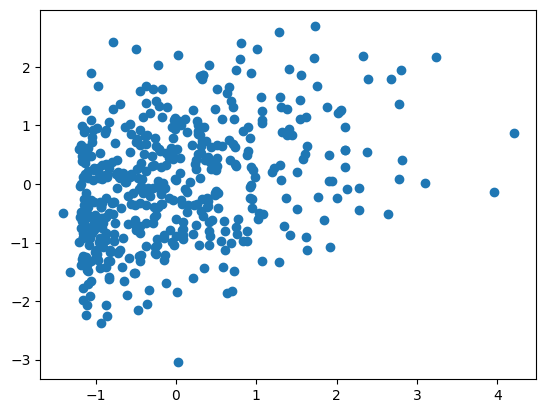

In [13]:
plt.scatter(model_data['dzdur'], model_data['LV_log'])